# 1. Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import *
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
tqdm.pandas()

from src.helpers import get_project_dir, load_model, save_model
from src.functions_and_methods import custom_score, group, eval, cross_validate_, Selector, get_new_feats

import warnings
warnings.filterwarnings("ignore")

# 2. Importing Data

In [2]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/train_data.csv')).rename(columns={'timestamp': 'date'})
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/validation_data.csv')).rename(columns={'hour': 'date'})
df_t = pd.read_excel(os.path.join(get_project_dir(), 'data/test_data.xlsx')).rename(columns={'hour': 'date'})

In [3]:
# Timestamp -> Datetime
tqdm.pandas()
df['date'] = df['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df = df.sort_values(by='date')
df_v['date'] = df_v['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_v = df_v.sort_values(by='date')
df_t['date'] = df_t['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_t = df_t.sort_values(by='date')

  0%|          | 0/8526526 [00:00<?, ?it/s]

  0%|          | 0/686 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

# 3. Outliers detection

##  3.1. lon & lat

In [6]:
points1 = df.drop_duplicates(subset='point')[['point','lon','lat']] \
           .sort_values(by='lon')

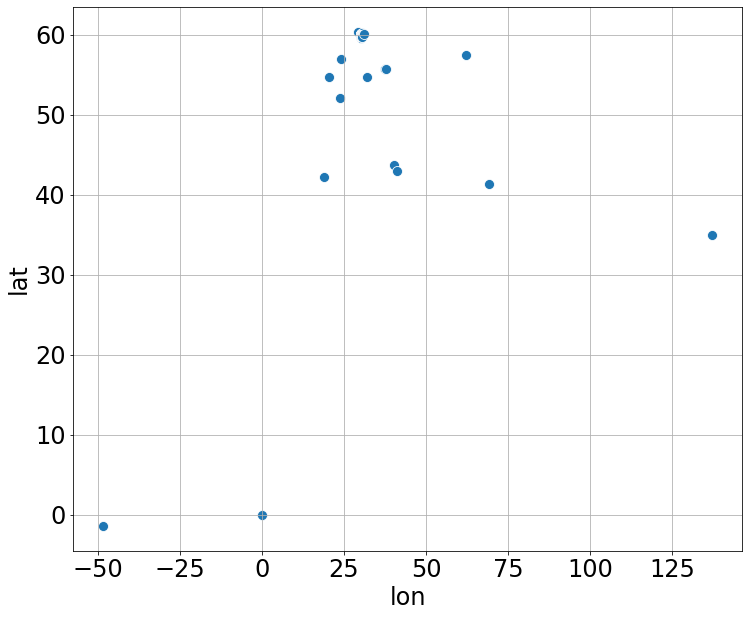

In [26]:
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': 24, 'lines.markersize': 10})
sns.scatterplot(data=points1, x='lon', y='lat')
plt.grid()

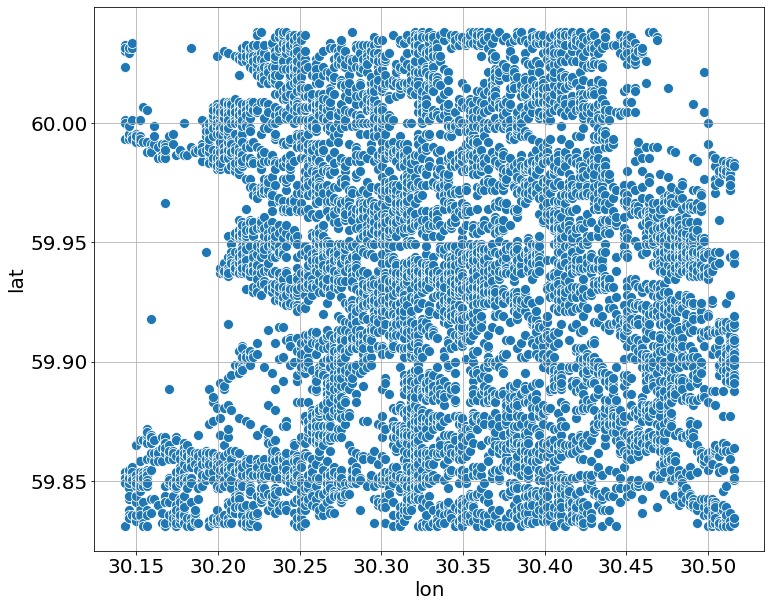

In [28]:
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': 20, 'lines.markersize': 10})
points2 = points1[points1['lon']>=30.142969][points1['lon']<=30.515771] \
                 [points1['lat']>=59.831191][points1['lat']<=60.039332]
sns.scatterplot(data=points2, x='lon', y='lat')
plt.grid()

In [17]:
print(f'Initial number of points: {len(points1)}')
print(f'Resulting number of points: {len(points2)}')
print(f'Number of outliers: {len(points1) - len(points2)}')
print(f'% of outliers: {round((len(points1) - len(points2))/len(points1)*100,1)}')

Initial number of points: 7041
Resulting number of points: 6658
Number of outliers: 383
% of outliers: 5.4


In [18]:
df2 = df[df['point'].isin(points2['point'])]
print(f'Initial number of observations: {len(df)}')
print(f'Resulting number of observations: {len(df2)}')
print(f'Number of outliers: {len(df) - len(df2)}')
print(f'% of outliers: {round((len(df) - len(df2))/len(df)*100,1)}')

Initial number of observations: 8526526
Resulting number of observations: 8293005
Number of outliers: 233521
% of outliers: 2.7


## 3.2. Isolation Forest (not included)

In [19]:
feats = ['lon', 'lat', 'likescount', 'commentscount', 'symbols_cnt', 'words_cnt', 
         'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt']
clf = IsolationForest(n_estimators=100, random_state=42, n_jobs=-1).fit(df2[feats])

In [20]:
df2['is_not_outlier'] = clf.predict(df2[feats])

In [21]:
df2['is_not_outlier'].value_counts()

is_not_outlier
 1    7440990
-1     852015
Name: count, dtype: int64

In [22]:
df3 = df2[df2['is_not_outlier']==1].drop('is_not_outlier', axis=1)
print(f'Initial number of observations: {len(df)}')
print(f'Resulting number of observations: {len(df3)}')
print(f'Number of outliers: {len(df) - len(df3)}')
print(f'% of outliers: {round((len(df) - len(df3))/len(df)*100,1)}')

Initial number of observations: 8526526
Resulting number of observations: 7440990
Number of outliers: 1085536
% of outliers: 12.7


# 4. Aggregating data (via mean values)

## Train set

In [29]:
df4 = group(df3)
df4

point  \
0        0101000020E610000002BF48199F3F3E400A41C338F1F6...   
1        0101000020E610000002BF48199F3F3E400A41C338F1F6...   
2        0101000020E610000002BF48199F3F3E400A41C338F1F6...   
3        0101000020E610000002BF48199F3F3E400A41C338F1F6...   
4        0101000020E610000002BF48199F3F3E400A41C338F1F6...   
...                                                    ...   
3239181  0101000020E6100000FF83F06FD7633E40FBF1162D20EC...   
3239182  0101000020E6100000FF83F06FD7633E40FBF1162D20EC...   
3239183  0101000020E6100000FF83F06FD7633E40FBF1162D20EC...   
3239184  0101000020E6100000FF83F06FD7633E40FBF1162D20EC...   
3239185  0101000020E6100000FF83F06FD7633E40FBF1162D20EC...   

                       date  likescount_sum  count  commentscount_sum  \
0       2019-01-01 16:00:00             102      1                  0   
1       2019-01-02 12:00:00              17      1                  1   
2       2019-01-02 13:00:00              17      1                  2   
3       2019-01-08 16:00:00              36      1                  0   
4       2019-01-12 11:00:00              57      1                  2   
...                     ...             ...    ...                ...   
3239181 2020-01-31 06:00:00              13      1                  2   
3239182 2020-01-31 10:00:00              31      1                  4   
3239183 2020-01-31 13:00:00             105      1                  5   
3239184 2020-01-31 14:00:00              20      1                  0   
3239185 2020-01-31 16:00:00              32      1                  1   

         symbols_cnt_sum  words_cnt_sum  hashtags_cnt_sum  mentions_cnt_sum  \
0                      3              0                 0                 0   
1                     66              8                 0                 0   
2                     68              8                 0                 0   
3                    102             14                 0                 0   
4                    129             15                 0                 0   
...                  ...            ...               ...               ...   
3239181              725             54                 5                 0   
3239182              738             42                18                 0   
3239183              112             10                 0                 1   
3239184              153             12                 0                 0   
3239185              423              2                30                 0   

         links_cnt_sum  emoji_cnt_sum   lon_mean   lat_mean  
0                    0              1  30.248521  59.929237  
1                    0              0  30.248521  59.929237  
2                    0              0  30.248521  59.929237  
3                    0              0  30.248521  59.929237  
4                    0              0  30.248521  59.929237  
...                ...            ...        ...        ...  
3239181              0             13  30.390006  59.844732  
3239182              0              0  30.390006  59.844732  
3239183              0              0  30.390006  59.844732  
3239184              0              4  30.390006  59.844732  
3239185              0              1  30.390006  59.844732  

[3239186 rows x 13 columns]

In [30]:
df4.to_csv(os.path.join(get_project_dir(), 'data/d2/train_data2.csv'), index=False)

# 5. Feature Engineering (new time-based features)

## Time based features

### Train

In [31]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/train_data2.csv'))

In [35]:
df['date'] = df['date'].astype('datetime64[ns]')
df['new'] = df['date'].progress_apply(lambda x: get_new_feats(x))
feats = ['hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning', 'is_day',
         'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
df[feats] = pd.DataFrame(df['new'].tolist(), index=df.index)
df = df.drop('new', axis=1) \
       .rename(columns={'lon_mean': 'lon', 'lat_mean': 'lat'})

  0%|          | 0/3239186 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
df.to_csv(os.path.join(get_project_dir(), 'data/d2/train_data3.csv'), index=False)

### Val

In [59]:
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/validation_data.csv')).rename(columns={'hour': 'date'})
df_v['date'] = df_v['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_v = df_v.sort_values(by='date') \
           .rename(columns={'sum': 'count'})

  0%|          | 0/686 [00:00<?, ?it/s]

In [60]:
df_v['date'] = df_v['date'].astype('datetime64')
df_v['new'] = df_v['date'].progress_apply(lambda x: get_new_feats(x))
feats = ['hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning', 'is_day',
         'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
df_v[feats] = pd.DataFrame(df_v['new'].tolist(), index=df_v.index)
df_v = df_v.drop('new', axis=1)

  0%|          | 0/686 [00:00<?, ?it/s]

### test

In [57]:
df_t = pd.read_excel(os.path.join(get_project_dir(), 'data/test_data.xlsx')) \
         .rename(columns={'hour': 'date'})
df_t['date'] = df_t['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_t = df_t.sort_values(by='date') \
           .rename(columns={'sum': 'count'})

  0%|          | 0/700 [00:00<?, ?it/s]

In [58]:
df_t['date'] = df_t['date'].astype('datetime64')
df_t['new'] = df_t['date'].progress_apply(lambda x: get_new_feats(x))
feats = ['hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning', 'is_day',
         'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
df_t[feats] = pd.DataFrame(df_t['new'].tolist(), index=df_t.index)
df_t = df_t.drop('new', axis=1)

  0%|          | 0/700 [00:00<?, ?it/s]

# 6. Feature Generation (based on training data)

In [14]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/train_data3.csv'))

### val

In [61]:
df_lag = df.groupby(['point', 'hour', 'month', 'weekday'], as_index=False) \
             .agg({'likescount_sum': 'mean',
                   'commentscount_sum': 'mean',
                   'symbols_cnt_sum': 'mean',
                   'mentions_cnt_sum': 'mean',
                   'links_cnt_sum': 'mean',
                   'emoji_cnt_sum': 'mean',
                   'words_cnt_sum': 'mean',
                   'hashtags_cnt_sum': 'mean'})

In [62]:
df_v = df_v.merge(df_lag, how='left')

In [63]:
df_v.to_csv(os.path.join(get_project_dir(), 'data/d2/val_data3.csv'), index=False)

### test

In [64]:
df_t = df_t.merge(df_lag, how='left')

In [66]:
df_t.to_csv(os.path.join(get_project_dir(), 'data/d2/test_data3.csv'), index=False)

# 7. Target Feature Distibution

<Axes: xlabel='count', ylabel='Density'>

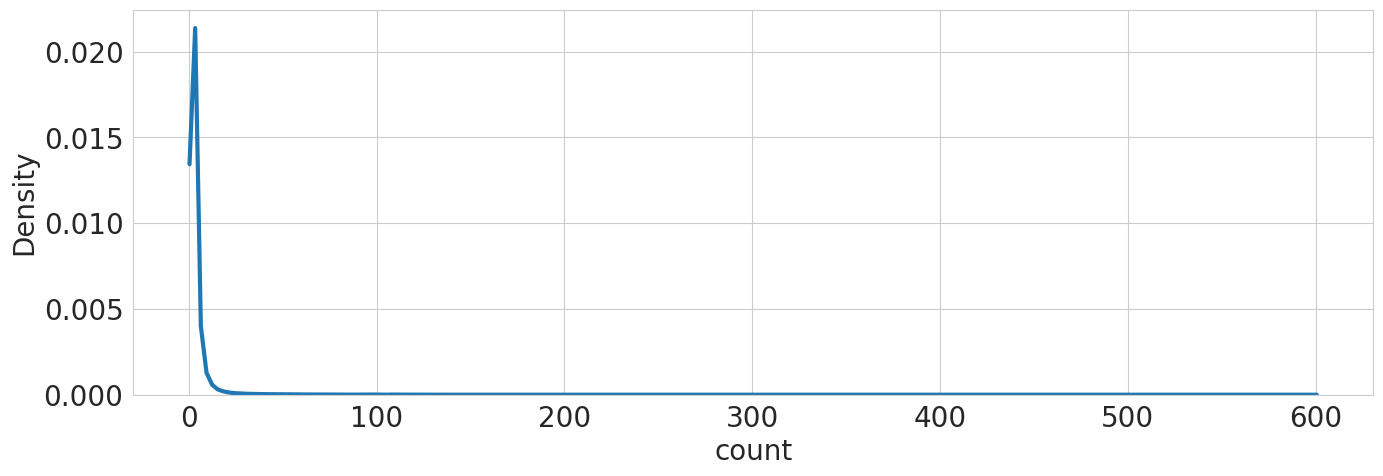

In [21]:
plt.figure(figsize=(16, 5))
plt.rcParams.update({'font.size': 20, 'lines.linewidth': 3, 'lines.markersize': 10})
sns.kdeplot(data=df, x='count')

# 7.1. Dummy Regressor

In [6]:
target = 'count'
_ = eval(DummyRegressor(strategy="mean"), df, df_v, df_t, ['lat'], target)

train R2 = 0.0
train custom = 0.7515452698328723
train MAPE = 0.948180896858257
train MAE = 1.7525184298002525
val R2 = -1.3510861596062074
val custom = 3.2233597548830164
val MAPE = 0.6941461777393207
val MAE = 7.516509787314776
test R2 = -1.308686248387347
test custom = 3.1523703034673094
test MAPE = 0.6880007524468306
test MAE = 7.350970428714193


# 7.2. RFR

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
%%time
feats = ['lat',
 'lon',
 'hour',
 'is_working_day',
 'is_day',
 'weekday',
 'is_evening',
 'is_weekend',
 'is_night',
 'year',
 'month',
 'day',
 'is_morning']
target = 'count'
_ = eval(RandomForestRegressor(max_depth=3), df, df_v, df_t, feats, target, is_fitted=False)

train R2 = 0.03601876671302673
train custom = 0.6929817843553887
train MAPE = 0.9153793732918852
train MAE = 1.7112268320241923
val R2 = -1.1878510525194872
val custom = 2.866458326535247
val MAPE = 0.6710536174267818
val MAE = 7.235967807756944
test R2 = -1.1441692868641948
test custom = 2.795091769751053
test MAPE = 0.6679053145885874
test MAE = 7.0930691031753845
CPU times: user 5min 28s, sys: 2.22 s, total: 5min 31s
Wall time: 5min 31s


In [13]:
%%time
feats = ['lat',
 'lon',
 'hour',
 'is_working_day',
 'is_day',
 'weekday',
 'is_evening',
 'is_weekend',
 'is_night',
 'year',
 'month',
 'day',
 'is_morning']
target = 'count'
_ = eval(RandomForestRegressor(max_depth=5, n_estimators=500), df, df_v, df_t, feats, target, is_fitted=False)

train R2 = 0.10321014091167291
train custom = 0.6456449460642437
train MAPE = 0.8559070281312465
train MAE = 1.6308154241534236
val R2 = -1.044065892823224
val custom = 2.558919032180544
val MAPE = 0.6518846661991907
val MAE = 6.941365457433568
test R2 = -0.9906866830134866
test custom = 2.495187138141297
test MAPE = 0.6439580583872607
test MAE = 6.763048199677454
CPU times: user 8min 28s, sys: 809 ms, total: 8min 29s
Wall time: 8min 29s


# 8. XGBoost

In [5]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42,
          'objective': 'reg:tweedie'}

In [2]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/train_data3.csv'))
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/val_data3.csv'))
df_t = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/test_data3.csv'))

## Only lan, lot, temp and time-based features (better results)

In [38]:
feats = ['lon', 'lat',
       'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day',
       'temp']
target = 'count'

In [11]:
%%time
eval(xgb.XGBRegressor(**params), df, df_v, df_t, feats, target, is_fitted=False)

train R2 = 0.47136104847462346
train custom = 0.4480387284529668
val R2 = -0.019645217618153854
val custom = 1.11710874892139
test R2 = -0.05200181292283701
test custom = 1.0258952164301829
CPU times: user 6min 3s, sys: 1.25 s, total: 6min 4s
Wall time: 26.1 s


## All features (worse results)

In [39]:
feats = ['likescount_sum', 'commentscount_sum',
       'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
       'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum', 'lon', 'lat',
       'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day',
       'temp']
target = 'count'

In [40]:
%%time
eval(xgb.XGBRegressor(**params), df, df_v, df_t, feats, target, is_fitted=False)

train R2 = 0.8587213475295588
train custom = 0.27389237467717903
val R2 = -0.37389145497706333
val custom = 1.4106611962001678
test R2 = -0.6504890302277349
test custom = 1.317290459064248
CPU times: user 6min 27s, sys: 1.37 s, total: 6min 29s
Wall time: 28 s


# 9. Feature selection (permutation importance)

## lat, lon, temp and time-based feats (better results)

In [105]:
feats = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
         'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
target = 'count'
model = xgb.XGBRegressor(**params)
model.fit(df[feats], df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [106]:
r = permutation_importance(model, df_v[feats], df_v[target], n_repeats=100, random_state=42)

In [107]:
imps = pd.DataFrame()
imps['feat'] = feats
imps['importance'] = r.importances_mean
imps = imps.sort_values(by='importance', ascending=False)
imps

feat  importance
1              lat    1.238307
0              lon    1.233237
2             hour    0.088918
13  is_working_day    0.016443
9           is_day    0.001125
10         weekday    0.000143
7       is_evening    0.000025
11      is_weekend    0.000000
6         is_night    0.000000
5             year    0.000000
4            month    0.000000
3              day   -0.000013
8       is_morning   -0.000049
12      is_holiday   -0.001540
14            temp   -0.002007

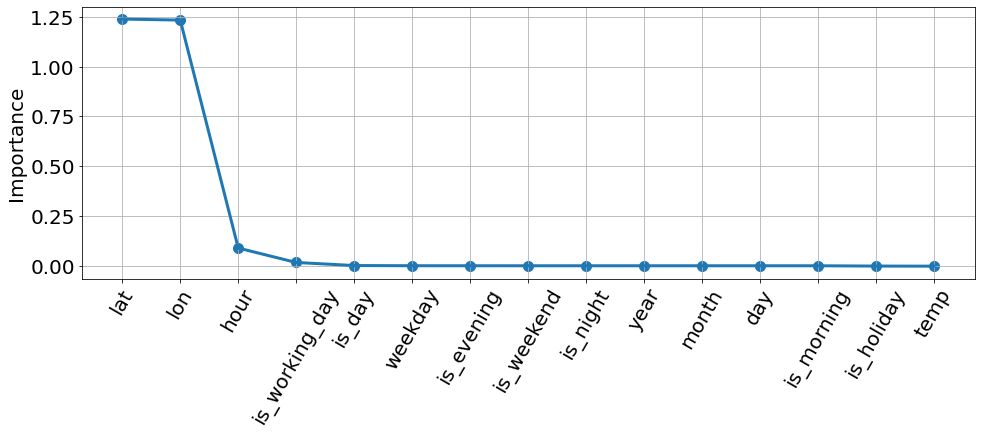

In [69]:
plt.figure(figsize=(16, 5))
plt.rcParams.update({'font.size': 20, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(range(len(imps)), imps['importance'].values)
plt.scatter(range(len(imps)), imps['importance'].values)
plt.xticks(ticks=range(len(imps)), labels=imps['feat'], rotation=60)
plt.ylabel('Importance')
plt.grid()

In [77]:
scores = []
for i in tqdm(range(15, 0, -1)):
    print('-'*30)
    print(i)
    scores_ = eval(xgb.XGBRegressor(**params), df, df_v, df_t, imps['feat'].tolist()[:i], target, is_fitted=False)
    scores.append(scores_)

  0%|          | 0/15 [00:00<?, ?it/s]

------------------------------
15
train R2 = 0.47136104847462346
train custom = 0.4480387284529668
val R2 = -0.019733438653514623
val custom = 1.1172701212265073
test R2 = -0.05200181292283701
test custom = 1.0258952164301829
------------------------------
14
train R2 = 0.4783823656113313
train custom = 0.4464525672963172
val R2 = 0.02417819051475134
val custom = 1.1055011607060912
test R2 = -0.016430920311311104
test custom = 1.009315972246464
------------------------------
13
train R2 = 0.4743835173214863
train custom = 0.4453291859274519
val R2 = 0.0017152812071213885
val custom = 1.0750101905224245
test R2 = -0.026081282302039543
test custom = 0.9763270333465273
------------------------------
12
train R2 = 0.4676701620666668
train custom = 0.44667882258087827
val R2 = -0.012349856088967881
val custom = 1.0955833556580366
test R2 = -0.050516663145902196
test custom = 1.0022165893682686
------------------------------
11
train R2 = 0.46530573593483626
train custom = 0.4457941552482518

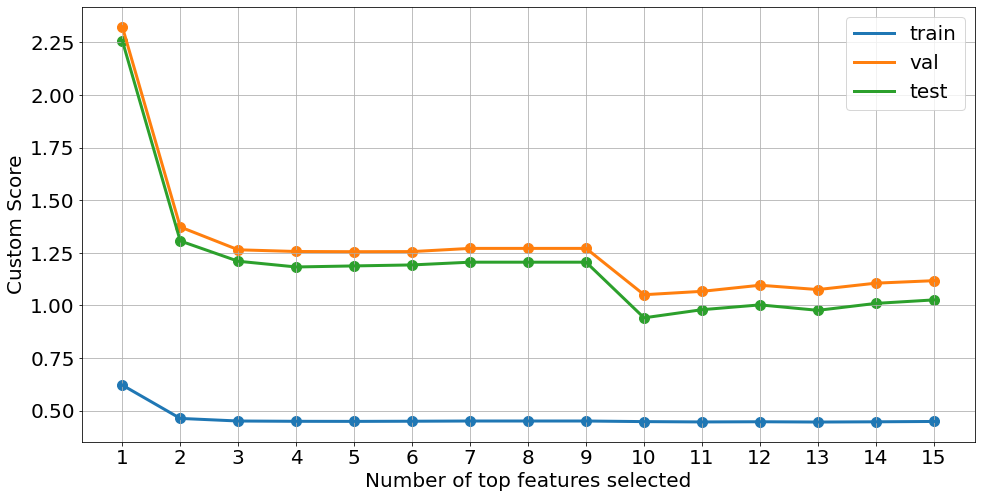

In [85]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 20, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(list(range(15, 0, -1)), [v['train custom'] for v in scores], label='train')
plt.scatter(list(range(15, 0, -1)), [v['train custom'] for v in scores])
plt.plot(list(range(15, 0, -1)), [v['val custom'] for v in scores], label='val')
plt.scatter(list(range(15, 0, -1)), [v['val custom'] for v in scores])
plt.plot(list(range(15, 0, -1)), [v['test custom'] for v in scores], label='test')
plt.scatter(list(range(15, 0, -1)), [v['test custom'] for v in scores])
plt.xlabel('Number of top features selected')
plt.ylabel('Custom Score')
plt.xticks(list(range(1, 16)))
plt.legend()
plt.grid()

## All features (worse results)

In [86]:
%%time
feats = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
       'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum', 'lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
target = 'count'
model = xgb.XGBRegressor(**params)
model.fit(df[feats], df[target])

CPU times: user 5min 34s, sys: 865 ms, total: 5min 35s
Wall time: 24 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [87]:
r = permutation_importance(model, df_v[feats], df_v[target], n_repeats=100, random_state=42)

In [88]:
imps = pd.DataFrame()
imps['feat'] = feats
imps['importance'] = r.importances_mean
imps = imps.sort_values(by='importance', ascending=False)
imps

feat  importance
0      likescount_sum    0.156397
9                 lat    0.127807
8                 lon    0.115999
1   commentscount_sum    0.068641
2     symbols_cnt_sum    0.062431
21     is_working_day    0.045912
10               hour    0.045532
18            weekday    0.010835
22               temp    0.002972
15         is_evening    0.002632
16         is_morning    0.000272
17             is_day    0.000046
12              month    0.000000
13               year    0.000000
14           is_night    0.000000
19         is_weekend    0.000000
6       links_cnt_sum   -0.000150
20         is_holiday   -0.003066
3       words_cnt_sum   -0.006954
7       emoji_cnt_sum   -0.010106
4    hashtags_cnt_sum   -0.010287
11                day   -0.015636
5    mentions_cnt_sum   -0.016357

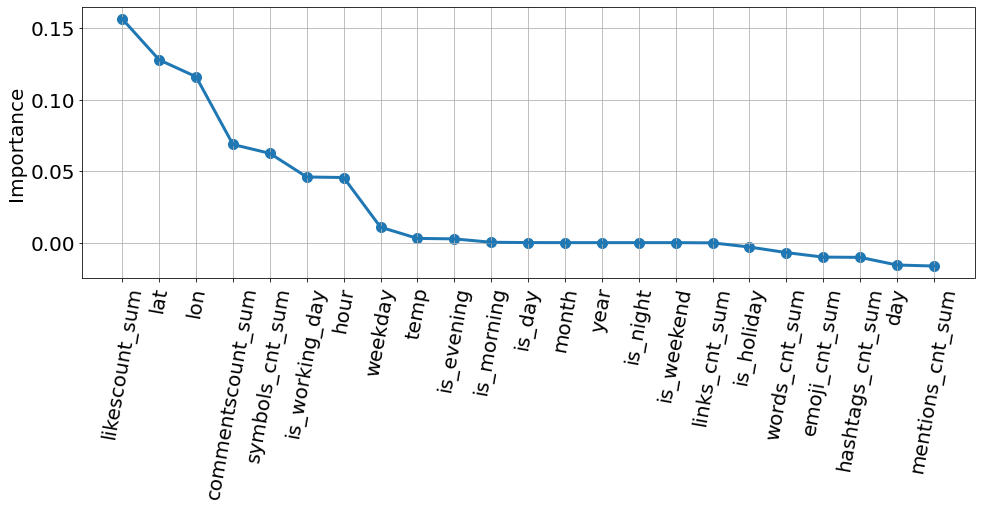

In [92]:
plt.figure(figsize=(16, 5))
plt.rcParams.update({'font.size': 20, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(range(len(imps)), imps['importance'].values)
plt.scatter(range(len(imps)), imps['importance'].values)
plt.xticks(ticks=range(len(imps)), labels=imps['feat'], rotation=80)
plt.ylabel('Importance')
plt.grid()

In [89]:
scores2 = []
for i in tqdm(range(len(imps), 0, -1)):
    print('-'*30)
    print(i)
    scores_ = eval(xgb.XGBRegressor(**params), df, df_v, df_t, imps['feat'].tolist()[:i], target, is_fitted=False)
    scores2.append(scores_)

  0%|          | 0/23 [00:00<?, ?it/s]

------------------------------
23
train R2 = 0.8587213475295588
train custom = 0.27389237467717903
val R2 = -0.37389145497706333
val custom = 1.4106611962001678
test R2 = -0.6504890302277349
test custom = 1.317290459064248
------------------------------
22
train R2 = 0.856446198364253
train custom = 0.2739826756853537
val R2 = -0.36750977463687184
val custom = 1.4036424404090828
test R2 = -0.663609429465198
test custom = 1.3116392075911008
------------------------------
21
train R2 = 0.8525971243601085
train custom = 0.2743657899557952
val R2 = -0.3470449315226949
val custom = 1.4131009837297364
test R2 = -0.7490824710839012
test custom = 1.3345038357622856
------------------------------
20
train R2 = 0.8403347740229441
train custom = 0.2813878678510721
val R2 = -0.36727735257432026
val custom = 1.4441881406674615
test R2 = -0.570853985038315
test custom = 1.3538883363719127
------------------------------
19
train R2 = 0.8319130174503828
train custom = 0.2854824020217988
val R2 = -0.40

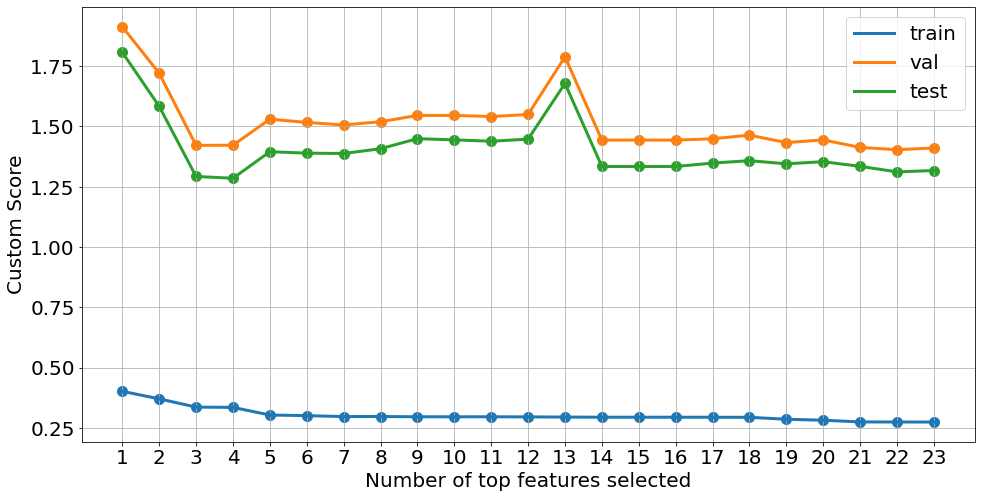

In [93]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 20, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(list(range(len(imps), 0, -1)), [v['train custom'] for v in scores2], label='train')
plt.scatter(list(range(len(imps), 0, -1)), [v['train custom'] for v in scores2])
plt.plot(list(range(len(imps), 0, -1)), [v['val custom'] for v in scores2], label='val')
plt.scatter(list(range(len(imps), 0, -1)), [v['val custom'] for v in scores2])
plt.plot(list(range(len(imps), 0, -1)), [v['test custom'] for v in scores2], label='test')
plt.scatter(list(range(len(imps), 0, -1)), [v['test custom'] for v in scores2])
plt.xlabel('Number of top features selected')
plt.ylabel('Custom Score')
plt.xticks(list(range(1, len(imps)+1)))
plt.legend()
plt.grid()

# 10. Feature selection (correlation) (not included)

In [94]:
feats1 = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
          'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
feats2 = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
          'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum']

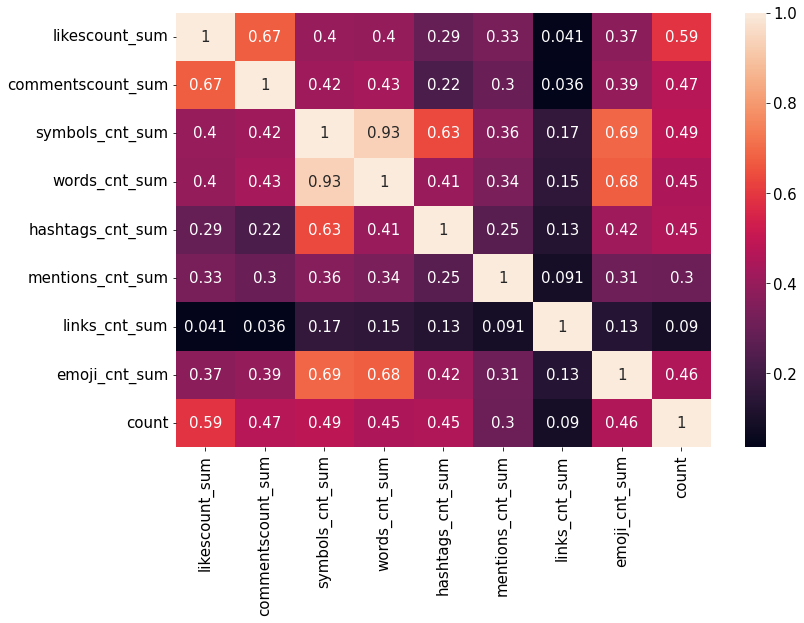

In [97]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'lines.markersize': 10})
sns.heatmap(df[feats2+['count']].corr('spearman'), annot = True)
plt.show()

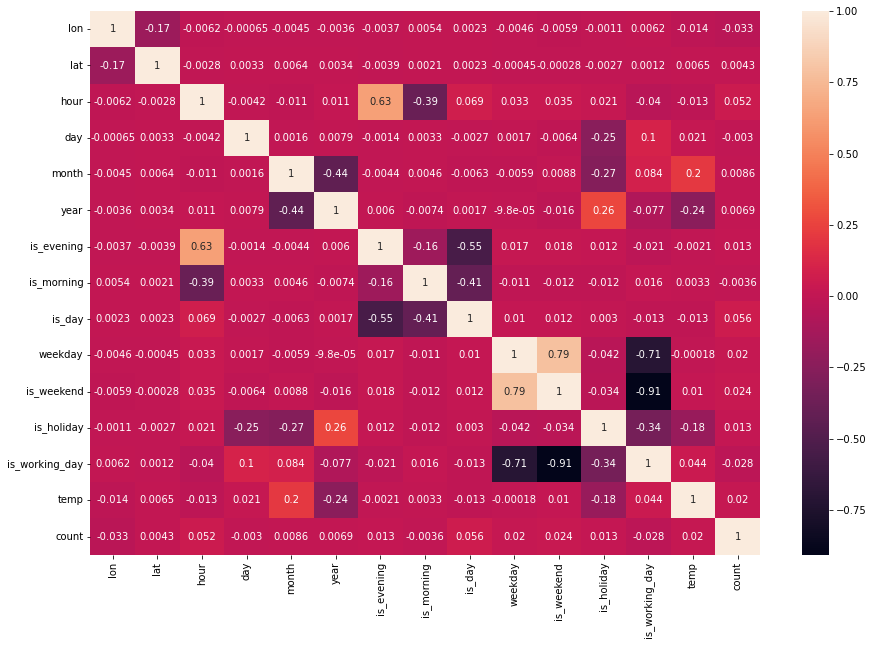

In [104]:
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 10, 'lines.linewidth': 3, 'lines.markersize': 10})
sns.heatmap(df[feats1+['count']].corr('spearman'), annot = True)
plt.show()

# 11. Feature selection (Greedy Search) (not included)

In [3]:
target = 'count'
default_features = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
          'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
features_to_select = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'mentions_cnt_sum', 'links_cnt_sum']

In [5]:
selector = Selector()
best_feats, best_score = selector.search(df=df, df_v=df_v, feats_to_select=features_to_select,
                                         default_feats=default_features, target=target,
                                         model=xgb.XGBRegressor, params=params, scorer=custom_score,
                                         max_steps=2)

Forward
----------------------------------------------------------------------
last_turn: 0, best_score: 100, best_feats_cnt: 0, curr_feats: []
new_feat: likescount_sum, score: 1.2506037603841487
UPDATING best set
best_feats: ['likescount_sum'], best_score: 1.2506037603841487
----------------------------------------------------------------------
last_turn: 0, best_score: 1.2506037603841487, best_feats_cnt: 1, curr_feats: ['likescount_sum']
new_feat: commentscount_sum, score: 1.236377366943159
UPDATING best set
best_feats: ['likescount_sum', 'commentscount_sum'], best_score: 1.236377366943159
----------------------------------------------------------------------
last_turn: 0, best_score: 1.236377366943159, best_feats_cnt: 2, curr_feats: ['likescount_sum', 'commentscount_sum']
new_feat: links_cnt_sum, score: 1.2467839239352383
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.236377366943159, best_feats_cnt: 2, curr_feats: [

In [3]:
params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
target = 'count'
default_features = ['lon', 'lat', 'hour', 'is_working_day', 'is_holiday', 'temp', 'is_day', 'day', 'weekday',
 'month', 'year', 'is_night', 'is_evening']
features_to_select = ['is_morning', 'is_weekend', 'commentscount_sum',
                      'symbols_cnt_sum', 'mentions_cnt_sum', 'links_cnt_sum',
                      'likescount_sum', 'words_cnt_sum', 'emoji_cnt_sum', 'hashtags_cnt_sum']

In [ ]:
selector = Selector()
best_feats, best_score = selector.search(df=df, df_v=df_v, feats_to_select=features_to_select,
                                         default_feats=default_features, target=target,
                                         model=xgb.XGBRegressor, params=params, scorer=custom_score,
                                         max_steps=4, initial_direction='forward', init_score=1.1390349656313783)

Forward
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: []
new_feat: likescount_sum, score: 1.5760570528770537
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: ['likescount_sum']
new_feat: words_cnt_sum, score: 1.5220962476171818
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: ['likescount_sum', 'words_cnt_sum']
new_feat: is_morning, score: 1.5220962476171818
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: ['likescount_sum', 'words_cnt_sum', 'is_morning']


In [9]:
selector = Selector()
best_feats, best_score = selector.search(df=df, df_v=df_v, feats_to_select=features_to_select,
                                         default_feats=default_features, target=target,
                                         model=xgb.XGBRegressor, params=params, scorer=custom_score,
                                         max_steps=3)

Forward
----------------------------------------------------------------------
last_turn: 0, best_score: 100, best_feats_cnt: 0, curr_feats: []
new_feat: likescount_sum, score: 1.9143901539673567
UPDATING best set
best_feats: ['likescount_sum'], best_score: 1.9143901539673567
----------------------------------------------------------------------
last_turn: 0, best_score: 1.9143901539673567, best_feats_cnt: 1, curr_feats: ['likescount_sum']
new_feat: year, score: 1.5765574292103466
UPDATING best set
best_feats: ['likescount_sum', 'year'], best_score: 1.5765574292103466
----------------------------------------------------------------------
last_turn: 0, best_score: 1.5765574292103466, best_feats_cnt: 2, curr_feats: ['likescount_sum', 'year']
new_feat: lat, score: 1.5531836114017337
UPDATING best set
best_feats: ['likescount_sum', 'year', 'lat'], best_score: 1.5531836114017337
----------------------------------------------------------------------
last_turn: 0, best_score: 1.55318361140173

# 12. Hyperparameters optimization (see VM2.ipynb)

In [8]:
feats = ['lat',
 'lon',
 'hour',
 'is_working_day',
 'is_day',
 'weekday',
 'is_evening',
 'is_weekend',
 'is_night',
 'year',
 'month',
 'day',
 'is_morning']
target = 'count'
best_set1 = {'lambda': 1, 
            'alpha': 1, 
            'max_depth': 10, 
            'learning_rate': 0.1, 
            'subsample': 1, 
            'colsample_bytree': 1,
            'random_state': 42,
            'n_estimators': 800, 
            'objective': 'reg:tweedie',
            'n_jobs': -1,}
best_set2 = {'random_state': 42,
             'max_depth': 8,
             'learning_rate': 0.21544346900318834,
             'lambda': 0.1,
             'alpha': 10,
             'n_estimators': 800, 
             'objective': 'reg:tweedie',
             'n_jobs': -1,
             'subsample': 1, 
             'colsample_bytree': 1}
best_set3 = {'lambda': 10.0, 
             'alpha': 0.46415888336127786, 
             'colsample_bytree': 1.0, 
             'subsample': 0.6, 
             'learning_rate': 0.1291549665014884, 
             'n_estimators': 1000, 
             'max_depth': 7, 
             'random_state': 42, 
             'min_child_weight': 120,
             'objective': 'reg:tweedie',
             'n_jobs': -1,}

In [9]:
default_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42,
          'objective': 'reg:tweedie'}
_ = eval(xgb.XGBRegressor(**default_params), df, df_v, df_t, feats, target, is_fitted=False)

train R2 = 0.4743835173214863
train custom = 0.4453291859274519
train MAPE = 0.553585333995555
train MAE = 1.1454825898162102
val R2 = 0.0017152812071213885
val custom = 1.0750101905224245
val MAPE = 0.43415051491248796
val MAE = 4.51049930552352
test R2 = -0.026081282302039543
test custom = 0.9763270333465273
test MAPE = 0.4194890096261766
test MAE = 4.4039529824256896


In [7]:
default_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42,
          'objective': 'reg:tweedie'}
_ = eval(xgb.XGBRegressor(**default_params), df, df_v, df_t, feats, target, is_fitted=False)

train R2 = 0.4743835173214863
train custom = 0.4453291859274519
train MAPE = 0.553585333995555
val R2 = 0.0017152812071213885
val custom = 1.0750101905224245
val MAPE = 0.43415051491248796
test R2 = -0.026081282302039543
test custom = 0.9763270333465273
test MAPE = 0.4194890096261766


# 13. Results for the best models

## Best set 1: train: 0.335, val: 0.861, test: 0.796

In [10]:
_ = eval(xgb.XGBRegressor(**best_set1), df, df_v, df_t, feats, target)

train R2 = 0.8228701224451559
train custom = 0.33596298644674
train MAPE = 0.38840177592568476
train MAE = 0.817089786534968
val R2 = 0.03853573950207445
val custom = 0.8612055245999325
val MAPE = 0.41335189230705194
val MAE = 4.098134671199426
test R2 = 0.055326319052883655
test custom = 0.7957875583639186
test MAPE = 0.39650499861890753
test MAE = 3.918856340817043


In [11]:
model = xgb.XGBRegressor(**best_set1)
model.fit(df[feats], df[target])

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=1,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=-1, ...)

### test

In [12]:
df_t['pred'] = model.predict(df_t[feats])
df_t['score'] = np.abs(df_t['pred'] - df_t['count']) / df_t['pred']
df_t_sorted = df_t[['count', 'pred', 'score']].sort_values(by='score')

In [13]:
df_t.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions1_test.csv'))

In [49]:
points = df_t.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')
points1 = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})
points_train = points1[points1['lon']>=30.142969][points1['lon']<=30.515771] \
                      [points1['lat']>=59.831191][points1['lat']<=60.039332]

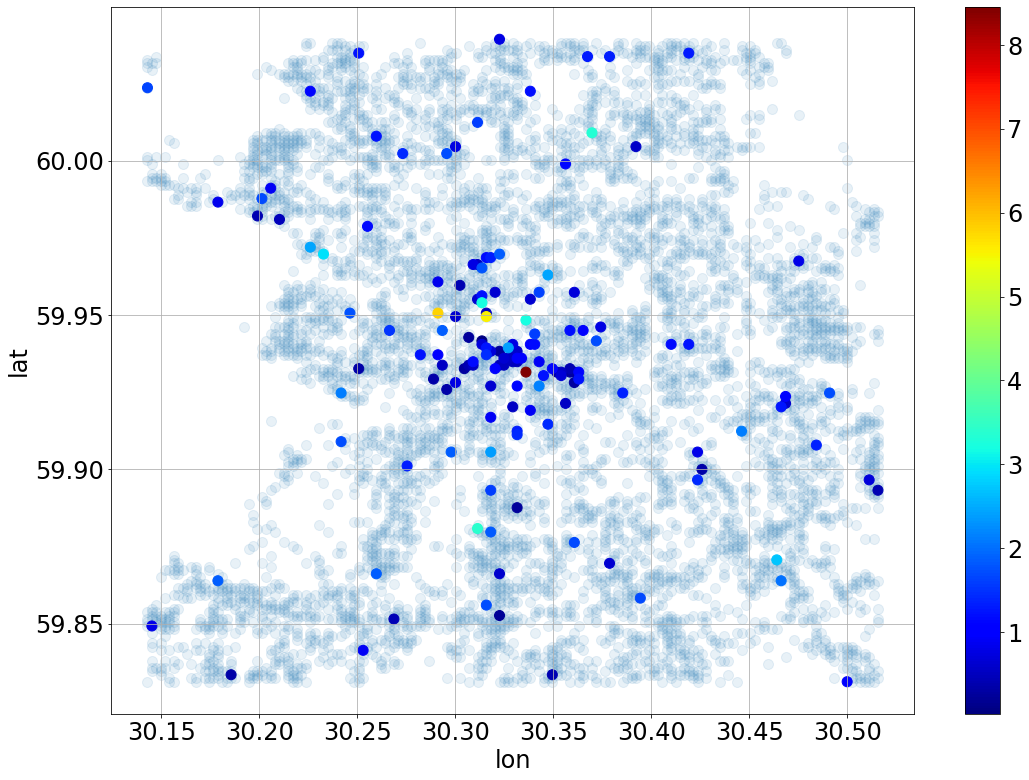

In [50]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18, 13))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.1)
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.grid()
cbar = plt.colorbar()

### val

In [41]:
df_v['pred'] = model.predict(df_v[feats])
df_v['score'] = np.abs(df_v['pred'] - df_v['count']) / df_v['pred']
df_v_sorted = df_v[['count', 'pred', 'score']].sort_values(by='score')

In [44]:
df_v.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions1_val.csv'))

In [51]:
points = df_v.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')[points1['lon']<=30.515771]
points1 = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})
points_train = points1[points1['lon']>=30.142969][points1['lon']<=30.515771] \
                      [points1['lat']>=59.831191][points1['lat']<=60.039332]

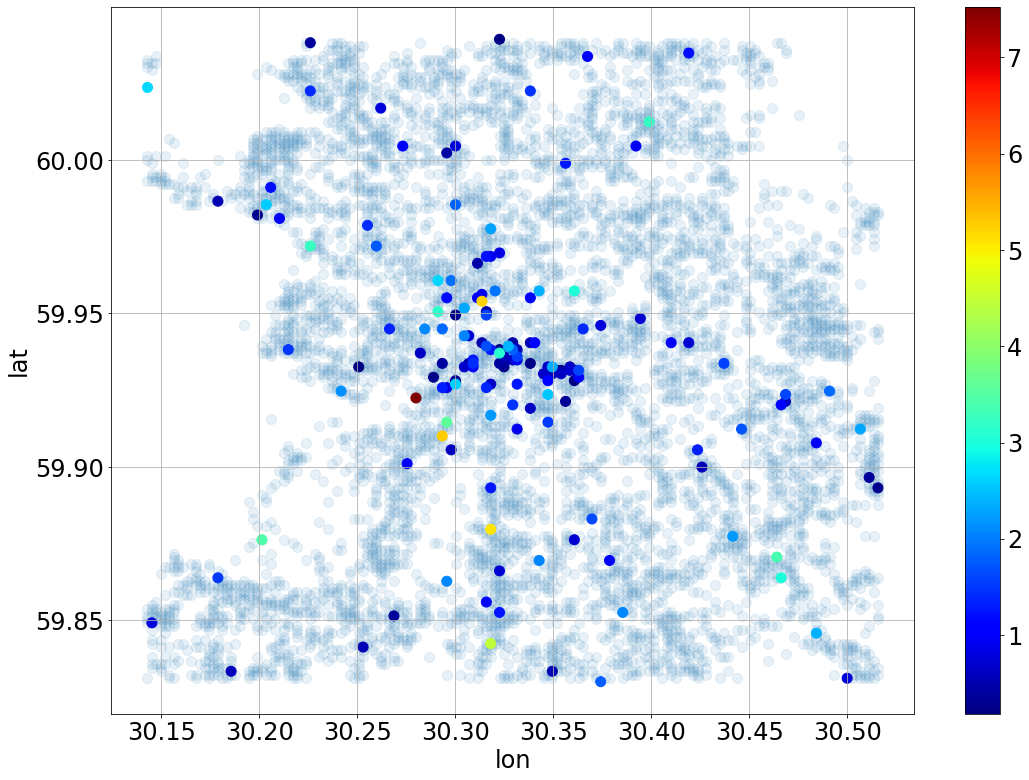

In [52]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18, 13))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.1)
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.grid()
cbar = plt.colorbar()

### both

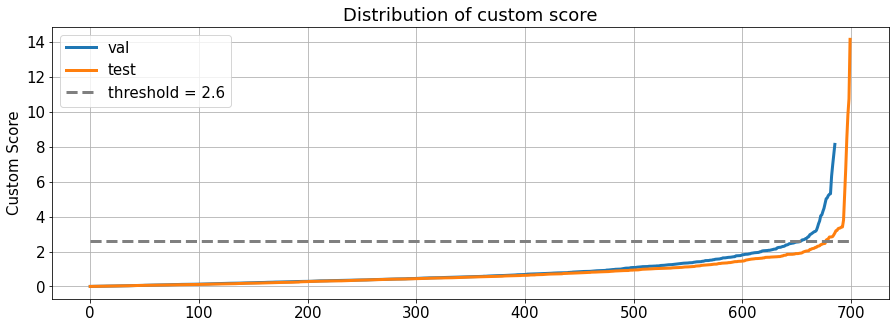

In [58]:
plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(df_v_sorted['score'].values, label='val')
plt.plot(df_t_sorted['score'].values, label='test')
plt.plot([0, len(df_t_sorted)], [2.6, 2.6], '--', color='grey', label='threshold = 2.6')
plt.title('Distribution of custom score')
plt.ylabel('Custom Score')
plt.grid()
plt.legend()
plt.show()

## Best set 2: train: 0.352, val: 0.870, test: 0.805

In [11]:
_ = eval(xgb.XGBRegressor(**best_set2), df, df_v, df_t, feats, target)

train R2 = 0.7901375110742683
train custom = 0.35192907377568583
train MAPE = 0.4081536760123171
train MAE = 0.8549899456958869
val R2 = 0.0727336728925363
val custom = 0.8696758260512574
val MAPE = 0.40813731312191714
val MAE = 4.082368085926546
test R2 = 0.08429877087588855
test custom = 0.804591061040152
test MAPE = 0.39564153080967907
test MAE = 3.9537833206994195


In [59]:
model2 = xgb.XGBRegressor(**best_set2)
model2.fit(df[feats], df[target])

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=0.1,
             learning_rate=0.21544346900318834, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=-1, ...)

### test

In [64]:
df_t['pred'] = model2.predict(df_t[feats])
df_t['score'] = np.abs(df_t['pred'] - df_t['count']) / df_t['pred']
df_t_sorted = df_t[['count', 'pred', 'score']].sort_values(by='score')

In [65]:
df_t.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions2_test.csv'))

In [66]:
points = df_t.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')
points1 = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})
points_train = points1[points1['lon']>=30.142969][points1['lon']<=30.515771] \
                      [points1['lat']>=59.831191][points1['lat']<=60.039332]

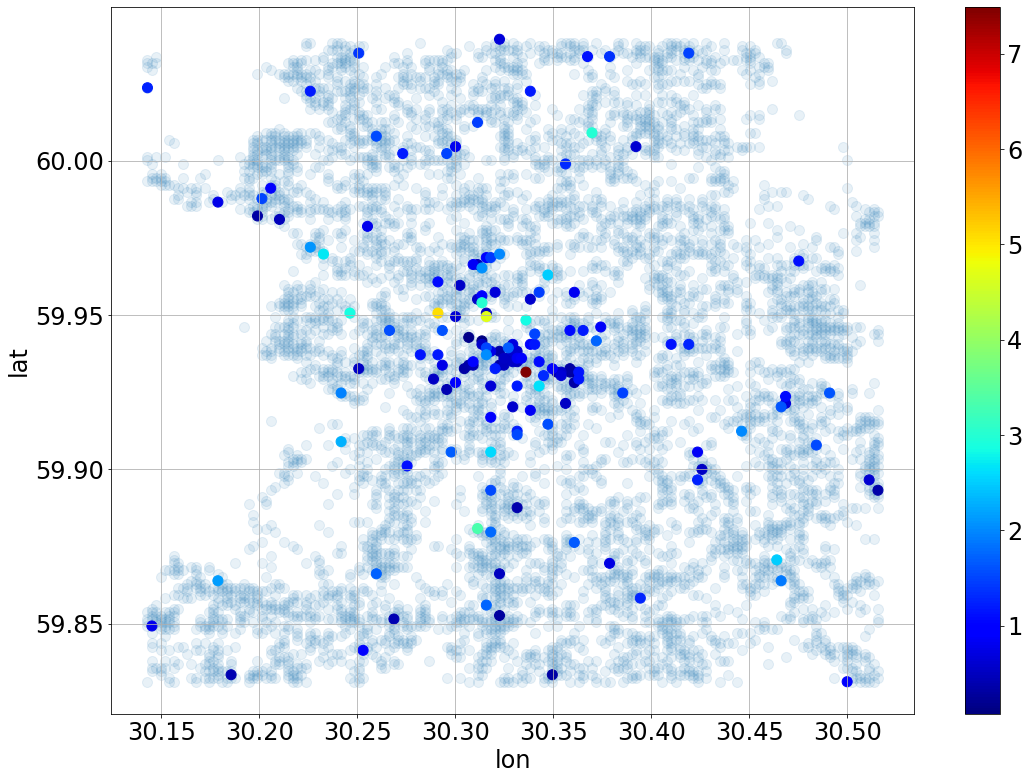

In [67]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18, 13))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.1)
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.grid()
cbar = plt.colorbar()

### val

In [68]:
df_v['pred'] = model2.predict(df_v[feats])
df_v['score'] = np.abs(df_v['pred'] - df_v['count']) / df_v['pred']
df_v_sorted = df_v[['count', 'pred', 'score']].sort_values(by='score')

In [69]:
df_v.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions2_val.csv'))

In [70]:
points = df_v.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')[points1['lon']<=30.515771]
points1 = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})
points_train = points1[points1['lon']>=30.142969][points1['lon']<=30.515771] \
                      [points1['lat']>=59.831191][points1['lat']<=60.039332]

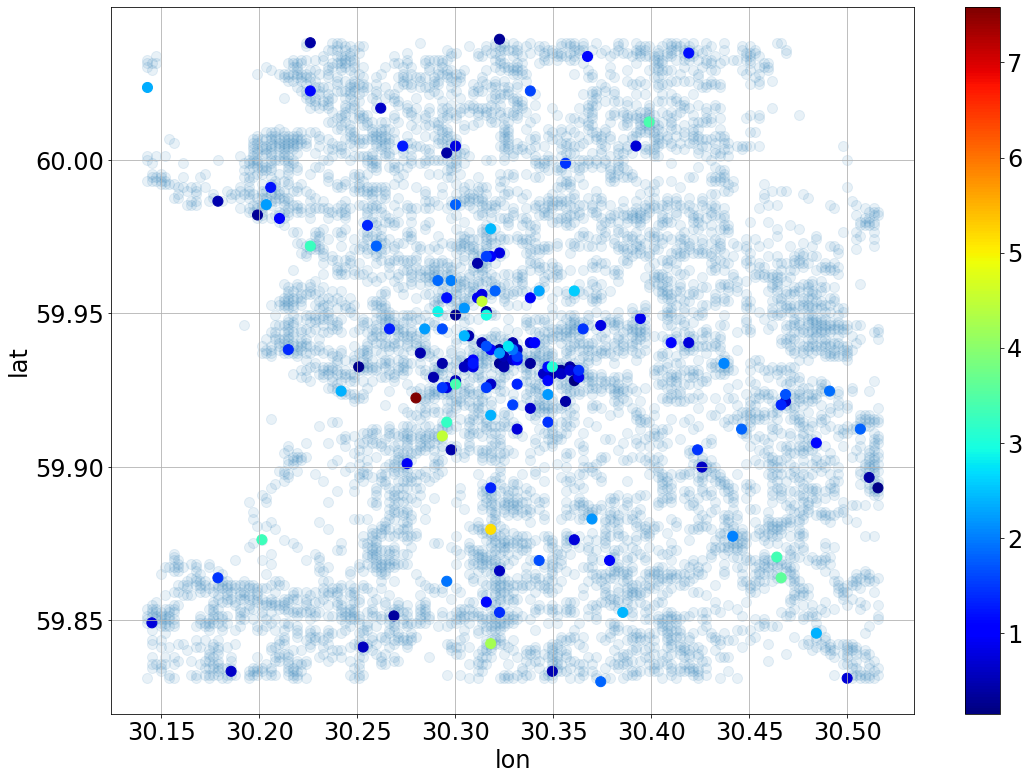

In [71]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18, 13))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.1)
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.grid()
cbar = plt.colorbar()

### both

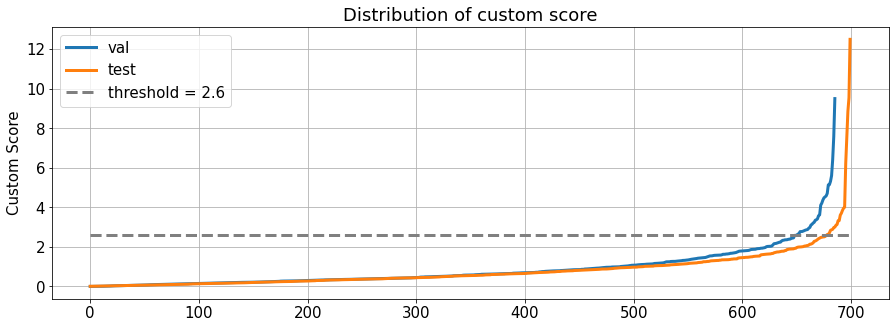

In [72]:
plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(df_v_sorted['score'].values, label='val')
plt.plot(df_t_sorted['score'].values, label='test')
plt.plot([0, len(df_t_sorted)], [2.6, 2.6], '--', color='grey', label='threshold = 2.6')
plt.title('Distribution of custom score')
plt.ylabel('Custom Score')
plt.grid()
plt.legend()
plt.show()

## Best set 3: train: 0.373, val: 0.860, test: 0.791

In [12]:
_ = eval(xgb.XGBRegressor(**best_set3), df, df_v, df_t, feats, target)

train R2 = 0.7265602322242379
train custom = 0.37330737768773004
train MAPE = 0.4380876264782382
train MAE = 0.9168499776194678
val R2 = 0.2177051951848129
val custom = 0.8603163248837726
val MAPE = 0.40557570668571447
val MAE = 4.020260348611949
test R2 = 0.1683595378437288
test custom = 0.790969711253237
test MAPE = 0.3878212854007171
test MAE = 3.8626645263603754


In [79]:
%%time
model3 = xgb.XGBRegressor(**best_set3)
model3.fit(df[feats], df[target])

CPU times: user 17min 29s, sys: 1.63 s, total: 17min 31s
Wall time: 37 s


XGBRegressor(alpha=0.46415888336127786, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=10.0,
             learning_rate=0.1291549665014884, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=120, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1, ...)

### test

In [81]:
df_t['pred'] = model3.predict(df_t[feats])
df_t['score'] = np.abs(df_t['pred'] - df_t['count']) / df_t['pred']
df_t_sorted = df_t[['count', 'pred', 'score']].sort_values(by='score')

In [82]:
df_t.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions3_test.csv'))

In [83]:
points = df_t.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')
points1 = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})
points_train = points1[points1['lon']>=30.142969][points1['lon']<=30.515771] \
                      [points1['lat']>=59.831191][points1['lat']<=60.039332]

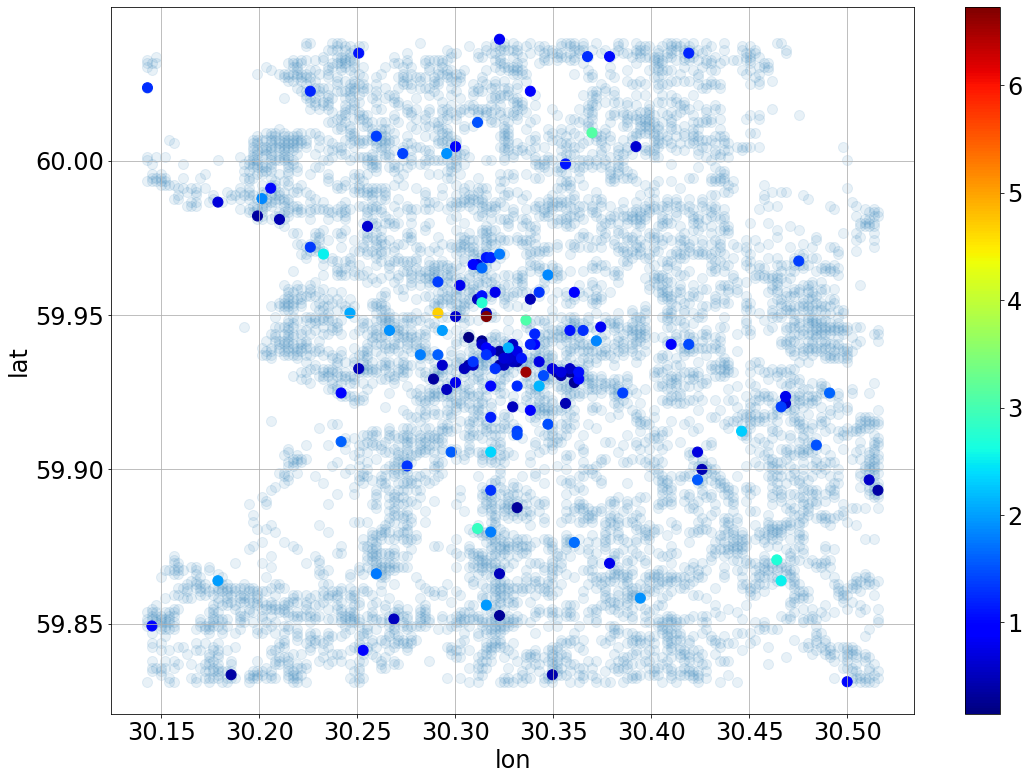

In [84]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18, 13))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.1)
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.grid()
cbar = plt.colorbar()

### val

In [85]:
df_v['pred'] = model3.predict(df_v[feats])
df_v['score'] = np.abs(df_v['pred'] - df_v['count']) / df_v['pred']
df_v_sorted = df_v[['count', 'pred', 'score']].sort_values(by='score')

In [86]:
df_v.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions3_val.csv'))

In [87]:
points = df_v.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')[points1['lon']<=30.515771]
points1 = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})
points_train = points1[points1['lon']>=30.142969][points1['lon']<=30.515771] \
                      [points1['lat']>=59.831191][points1['lat']<=60.039332]

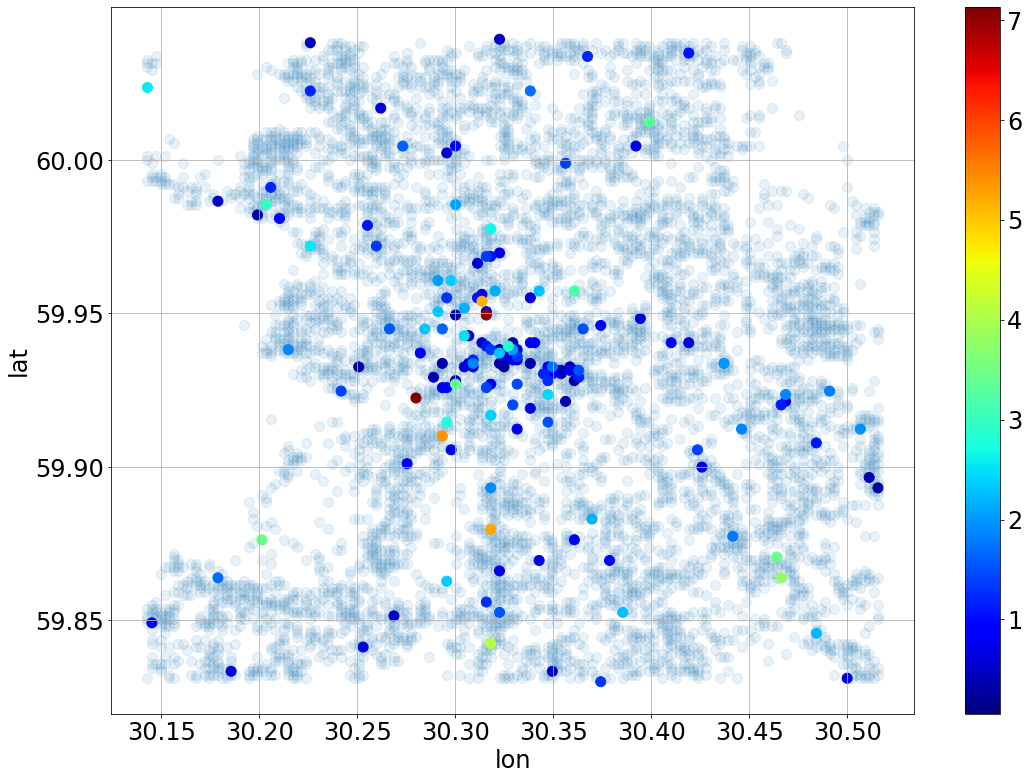

In [88]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18, 13))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.1)
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.grid()
cbar = plt.colorbar()

### both

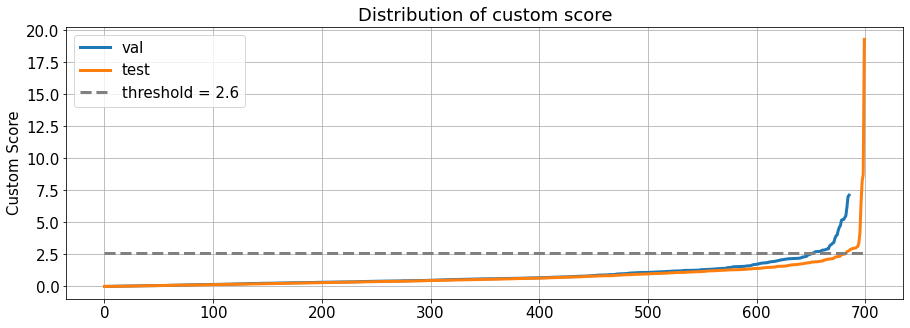

In [89]:
plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(df_v_sorted['score'].values, label='val')
plt.plot(df_t_sorted['score'].values, label='test')
plt.plot([0, len(df_t_sorted)], [2.6, 2.6], '--', color='grey', label='threshold = 2.6')
plt.title('Distribution of custom score')
plt.ylabel('Custom Score')
plt.grid()
plt.legend()
plt.show()

## Comparison

In [90]:
df_v1 = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions1_val.csv'))
df_t1 = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions1_test.csv'))
df_v2 = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions2_val.csv'))
df_t2 = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions2_test.csv'))
df_v3 = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions3_val.csv'))
df_t3 = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions3_test.csv'))

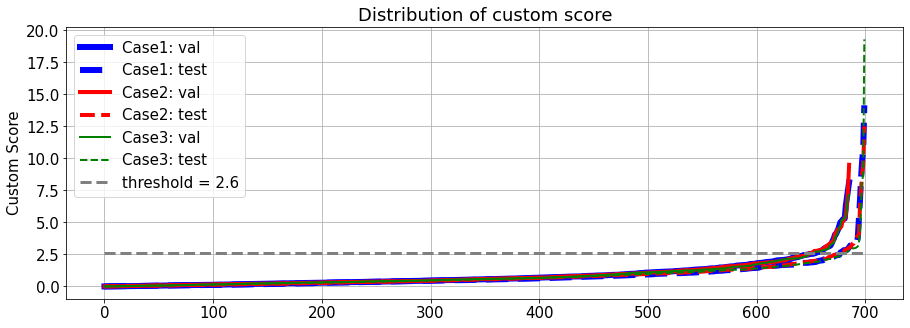

In [97]:
plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(df_v1[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '-', color='b', label='Case1: val', 
        linewidth=6)
plt.plot(df_t1[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '--', color='b', label='Case1: test',
        linewidth=6)
plt.plot(df_v2[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '-', color='r', label='Case2: val',
        linewidth=4)
plt.plot(df_t2[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '--', color='r', label='Case2: test',
        linewidth=4)
plt.plot(df_v3[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '-', color='g', label='Case3: val',
        linewidth=2)
plt.plot(df_t3[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '--', color='g', label='Case3: test',
        linewidth=2)
plt.plot([0, len(df_t_sorted)], [2.6, 2.6], '--', color='grey', label='threshold = 2.6')
plt.title('Distribution of custom score')
plt.ylabel('Custom Score')
plt.grid()
plt.legend()
plt.show()

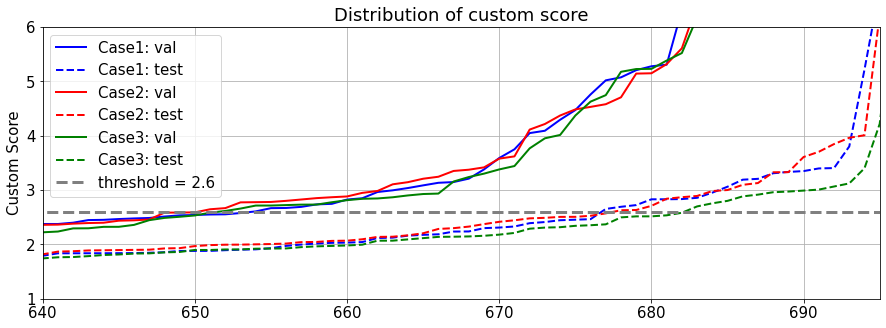

In [107]:
plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'lines.markersize': 10})
plt.plot(df_v1[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '-', color='b', label='Case1: val', 
        linewidth=2)
plt.plot(df_t1[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '--', color='b', label='Case1: test',
        linewidth=2)
plt.plot(df_v2[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '-', color='r', label='Case2: val',
        linewidth=2)
plt.plot(df_t2[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '--', color='r', label='Case2: test',
        linewidth=2)
plt.plot(df_v3[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '-', color='g', label='Case3: val',
        linewidth=2)
plt.plot(df_t3[['count', 'pred', 'score']].sort_values(by='score')['score'].values, '--', color='g', label='Case3: test',
        linewidth=2)
plt.plot([0, len(df_t_sorted)], [2.6, 2.6], '--', color='grey', label='threshold = 2.6')
plt.title('Distribution of custom score')
plt.ylabel('Custom Score')
plt.grid()
plt.legend()
plt.xlim(640, 695)
plt.ylim(1, 6)
plt.show()

In [ ]:
len()